# BigDL-Nano Inference Demo

BigDL-Nano provides a set of lightweight APIs for accelerating the inference pipeline. This demo illustrates how to apply these APIs on a [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/) based application. This notebook is modified from the original [FastFace inference example](https://github.com/borhanMorphy/fastface/blob/master/doc_samples/inference.py).

With these optimizations provided by BigDL-Nano, we could achieve 2x times faster than the official PyTorch Lightning code.

### 1-line of code change to use BigDL-Nano

To use BigDL-Nano to acclerate inference, the first change we made to the original PyTorch Lightning code is to replace the original import of `pytorch_lightning.Trainer` with `bigdl.nano.pytorch.trainer.Trainer`, as shown below.

Under the hood, various optimization tools (including ONNX Runtime, INC, OpenVINO, etc.) are automatically enabled. 

For more details, you may refer to [BigDL 2.0 paper](https://arxiv.org/abs/2204.01715) and [BigDL-Nano docs](circuit.intel.com/content/news/home/circuithome.html).

In [1]:
# from pytorch_lightning import Trainer
from bigdl.nano.pytorch.trainer import Trainer

In [2]:
import os
import time
import torch
import fastface as ff
import imageio
from PIL import Image

#### step1 : define train dataloader 

A training dataloader for calibration is required for static quantization. At the mean time, it can provide an input example to convert pytorch model into ONNX Runtime or OpenVINO.

In [3]:
train_transforms = ff.transforms.Compose(
    ff.transforms.Interpolate(target_size=480),
    ff.transforms.Padding(target_size=(480, 480)),
    ff.transforms.RandomHorizontalFlip(p=0.5),
)

train_dl = ff.dataset.FDDBDataset(
    phase=None, transforms=train_transforms, folds=[2],
).get_dataloader(batch_size=1, shuffle=False, num_workers=0)

train_loader_iter = iter(train_dl)

#### step 2 : load the pre-trained model

When there is no face in the predicted picture, the NMS operation in the post-processing function may lead to the error of the accelerated model. Therefore, here we rewrite the forward and predict functions to decouple the NMS post-processing and forward calculation.

In other cases, you don't need to change the model.


In [4]:
model = ff.FaceDetector.from_pretrained("lffd_slim")
model.eval()

def predict(new_model, img_input):
    batch = model.to_tensor(img_input)
    # batch: list of tensors
    batch_size = len(batch)
    batch, scales, paddings = ff.utils.preprocess.prepare_batch(batch, target_size=480)
    start_t = time.time()
    preds = new_model(batch)
    end_t = time.time()
    preds = [preds[preds[:, 5] == batch_idx, :5] for batch_idx in range(batch_size)]
    preds = ff.utils.preprocess.adjust_results(preds, scales, paddings)
    preds = model.to_json(preds)
    return preds, end_t - start_t

#### step3 : load a test image
[below image](https://pic.52112.com/2020/04/13/JPG-200413_214/6dlfS77hVV_small.jpg) is downloaded from Internet.

In [5]:
# load image
img_filepath = "./data/face_det.png"
img = imageio.imread(img_filepath)[:, :, :3]

#### step4: inference

## Original inference



In [6]:
# find facespr
start_t = time.time()
preds, infer_time = predict(model, img)
(preds,) = preds
print("prediction cost total {:.4f}s".format(time.time() - start_t))
print("infer cost {:.4f}s".format(infer_time))

# visualize predictions
pil_img = ff.utils.vis.render_predictions(img, preds)
img_save_path = "./data/infer_image_default.png"
pil_img.save(img_save_path)

prediction cost total 0.1236s
infer cost 0.1052s


In [7]:
num_images = 20
with torch.no_grad():
    start = time.perf_counter()
    for _ in range(num_images):
        preds, infer_time = predict(model, img)
    end = time.perf_counter()
    time_torch = end - start
print(
    f"Normal inference on CPU: {time_torch/num_images:.3f} seconds per image, "
    f"FPS: {num_images/time_torch:.2f}")

Normal inference on CPU: 0.040 seconds per image, FPS: 25.24


## Accelerate by Trainer.trace

BigDL-Nano provides Trainer.trace for accelerating, you can accelerate your model by [ONNX Runtime](https://onnxruntime.ai/) with just one line of code.

### onnxruntime accelerator


In [8]:
onnx_model = Trainer.trace(model, input_sample=next(train_loader_iter)[0], accelerator='onnxruntime')

/opt/anaconda3/envs/nano/lib/python3.7/site-packages/torch/onnx/symbolic_opset9.py:2766: UserWarning: Exporting aten::index operator of advanced indexing in opset 11 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  "If indices include negative values, the exported graph will produce incorrect results.")
/opt/anaconda3/envs/nano/lib/python3.7/site-packages/torch/onnx/symbolic_opset9.py:701: UserWarning: This model contains a squeeze operation on dimension 1 on an input with unknown shape. Note that if the size of dimension 1 of the input is not 1, the ONNX model will return an error. Opset version 11 supports squeezing on non-singleton dimensions, it is recommended to export this model using opset version 11 or higher.
  "version 11 or higher.")


/opt/anaconda3/envs/nano/lib/python3.7/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py
model path tmp.onnx


2022-06-20 09:06:22.399921954 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer '504'. It is not used by any node and should be removed from the model.


prediction cost total 0.0383s
infer cost 0.0158s


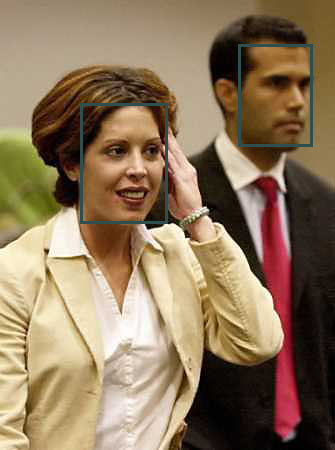

In [9]:
# find facespr
start_t = time.time()
preds, infer_time = predict(onnx_model, img)
(preds,) = preds
print("prediction cost total {:.4f}s".format(time.time() - start_t))
print("infer cost {:.4f}s".format(infer_time))

# visualize predictions
pil_img = ff.utils.vis.render_predictions(img, preds)
img_save_path = "./data/infer_image_trace_onnx.png"
pil_img.save(img_save_path)
display(Image.open(img_save_path))

In [11]:
num_images = 20
with torch.no_grad():
    start = time.perf_counter()
    for _ in range(num_images):
        preds, infer_time = predict(onnx_model, img)
    end = time.perf_counter()
    time_torch = end - start
print(
    f"ONNX Runtime inference on CPU: {time_torch/num_images:.3f} seconds per image, "
    f"FPS: {num_images/time_torch:.2f}")

ONNX Runtime inference on CPU: 0.019 seconds per image, FPS: 53.83


## Quantized by Trainer.quantize

You can quantize your model with just one line of code under the API of BigDL-Nano.

In [12]:
model_int8 = Trainer.quantize(model, precision='int8', accelerator="onnxruntime", method='integer', calib_dataloader=train_dl)

/opt/anaconda3/envs/nano/lib/python3.7/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py
model path tmp.onnx


2022-06-20 09:06:48.386628660 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer '504'. It is not used by any node and should be removed from the model.
2022-06-20 09:06:49.586088835 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer '504'. It is not used by any node and should be removed from the model.
2022-06-20 10:06:49 [INFO] Generate a fake evaluation function.
2022-06-20 09:06:49.676435756 [W:onnxruntime:, graph.cc:3526 CleanUnusedInitializersAndNodeArgs] Removing initializer '504'. It is not used by any node and should be removed from the model.
2022-06-20 10:06:49 [INFO] Get FP32 model baseline.
2022-06-20 10:06:49 [INFO] Save tuning history to /mnt/disk1/ruonanw/cvpr2022demo/nc_workspace/2022-06-20_10-06-49/./history.snapshot.
2022-06-20 10:06:49 [INFO] FP32 baseline is: [Accuracy: 1.0000, Duration (seconds): 0.0000]
2022-06-20 10:06:56 [INFO] |*******Mixed Precision Statistics*******|
2022-06-20 10:06:

/opt/anaconda3/envs/nano/lib/python3.7/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py
model path /tmp/tmp1uwp6cgx/tmp.onnx


In [13]:
# find facespr
start_t = time.time()
preds, infer_time = predict(model_int8, img)
(preds,) = preds
print("prediction cost total {:.4f}s".format(time.time() - start_t))
print("infer cost {:.4f}s".format(infer_time))
# visualize predictions
pil_img = ff.utils.vis.render_predictions(img, preds)
img_save_path = "./data/infer_image_quantize.png"
pil_img.save(img_save_path)

prediction cost total 0.1408s
infer cost 0.1094s


In [19]:
num_images = 20
with torch.no_grad():
    start = time.perf_counter()
    for _ in range(num_images):
        preds, infer_time = predict(model_int8, img)
    end = time.perf_counter()
    time_torch = end - start
print(
    f"Quantize inference on CPU: {time_torch/num_images:.3f} seconds per image, "
    f"FPS: {num_images/time_torch:.2f}")

Quantize inference on CPU: 0.066 seconds per image, FPS: 15.21


### Comparison of model size before and after quantize

Here we save the model by trainer.save() and print the model size. In this case, quantization reduces the size of the model to 75%.

In [21]:
def print_size_of_model(model):
    Trainer.save(model, "./temp.p")
    try:
        print('Original size : {:.2f} (MB)'.format(os.path.getsize("./temp.p/saved_weight.pt")/1e6))
        os.remove('./temp.p/saved_weight.pt')
        os.remove('./temp.p/nano_model_meta.yml')
    except:
        print('Quantization size : {:.2f} (MB)'.format(os.path.getsize("./temp.p/onnx_saved_model.onnx")/1e6))
        os.remove('./temp.p/onnx_saved_model.onnx')
        os.remove('./temp.p/nano_model_meta.yml')
    os.removedirs('./temp.p')

print_size_of_model(model)
print_size_of_model(model_int8)

Original size : 6.11 (MB)
Quantization size : 4.59 (MB)


## Latency of different models

Below tables shows the inference latency of original, traced and quantized models on our local environment. As shown in the table, BigDL-Nano can bring up to 1.5x speedup without much accuracy loss.

|  | original model | onnxruntime | quantize |
| :-----| ----: | :----: |  :----: |
|  Latency | 0.040s | 0.019s | 0.066s |
|  FPS | 24.24 | 53.83 | 15.21 |
|  Speedup | 1x | 2.22x | 0.63x  |